In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import shap

# Load data

In [2]:
df = pd.read_csv('data/Sentences_clean.csv')

In [3]:
df.head()

,ID,Sentence,Sentence_clean,sentiment
0,1,The results in 2nd line treatment show an ORR ...,results nd line treatment show orr patients d...,Positive
1,2,The long duration of response and high durable...,long duration response high durable response r...,Positive
2,4,"Therefore, the clinical benefit in 2nd line tr...",therefore clinical benefit nd line treatment c...,Positive
3,5,"The data provided in 1st line, although prelim...",data provided st line although preliminary sho...,Positive
4,6,Taking into account the intrinsic limitation o...,taking account intrinsic limitation single arm...,Positive


# Create simple features  

In [4]:
# create a simple set of features based on the original text

df['word_count'] = df["Sentence"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["Sentence"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['avg_word_length'] = df['char_count'] / df['word_count']

# Create features with VADER model

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
# create sentiment prediction from nltk VADER model as a feature
vader_features = pd.DataFrame()
sia = SentimentIntensityAnalyzer()

for sentence in df.Sentence_clean:
    vader_features = vader_features.append(sia.polarity_scores(sentence), ignore_index=True)
    
#rename columns
vader_features.rename(columns={'neg':'vader_neg', 'neu':'vader_neu', 'pos':'vader_pos', 'compound':'vader_compound'}, inplace=True)

In [7]:
df = pd.concat([df, vader_features], axis=1)

# Train-test-split

In [8]:
# create stratified train test split 

train, test = train_test_split(df, test_size=0.2, train_size=0.8, stratify=df['sentiment'], random_state=0)

In [9]:
# encode target

le = LabelEncoder()

le.fit(train['sentiment'])

train['target'] = le.transform(train['sentiment'])
test['target'] = le.transform(test['sentiment'])

In [10]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

# Create features based on word counts in train set

In [11]:
# create bag of words

countvectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_wordcount = countvectorizer.fit_transform(train['Sentence_clean']).toarray()
test_wordcount = countvectorizer.transform(test['Sentence_clean']).toarray()

In [12]:
# add features to train and test 
train[countvectorizer.get_feature_names_out()+'_cntvec'] = train_wordcount
test[countvectorizer.get_feature_names_out()+'_cntvec'] = test_wordcount

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [13]:
# create TF-IDF features

tfidfvectorizer = TfidfVectorizer(token_pattern=r'\b\w+\b')
train_tfidf = tfidfvectorizer.fit_transform(train['Sentence_clean']).toarray()
test_tfidf = tfidfvectorizer.transform(test['Sentence_clean']).toarray()

In [14]:
# add features to train and test 
train[tfidfvectorizer.get_feature_names_out()+'_tfidfvec'] = train_tfidf
test[tfidfvectorizer.get_feature_names_out()+'_tfidfvec'] = test_tfidf

# Finalize train and test set for model training

In [16]:
# remove unnecessary columns from train and test
X_train = train.drop(columns=['ID', 'Sentence','Sentence_clean', 'sentiment', 'target'])
X_test = test.drop(columns=['ID', 'Sentence','Sentence_clean', 'sentiment', 'target'])
y_train = train['target']
y_test = test['target']

In [17]:
# scale feature data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train simple logistic regression model

In [18]:
# logistic regression model

lr = LogisticRegression(random_state=0)

# fit
lr.fit(X_train_scaled,y_train)

LogisticRegression(random_state=0)

In [19]:
predictions = lr.predict(X_test_scaled)

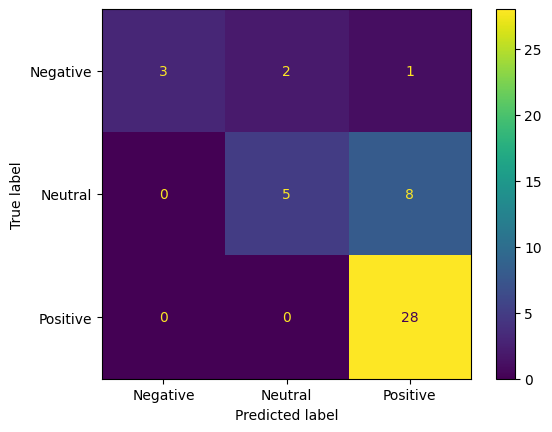

In [20]:
# plot confusions matrix

cf_matrix = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(cf_matrix, display_labels=le.classes_)

disp.plot()

plt.show()

In [21]:
print(classification_report(predictions,y_test, labels=[0,1,2], target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67         3
     Neutral       0.38      0.71      0.50         7
    Positive       1.00      0.76      0.86        37

    accuracy                           0.77        47
   macro avg       0.63      0.82      0.68        47
weighted avg       0.88      0.77      0.80        47



# Compare to further benchmark models

In [22]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [23]:
classifiers = {
    "BernoulliNB": BernoulliNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

In [24]:
# accuracy of naive classifier
accuracy_score(y_test, np.repeat(2,y_test.shape[0]))

0.5957446808510638

In [25]:
for name, sklearn_classifier in classifiers.items():
    
    sklearn_classifier.fit(X_train_scaled, y_train)
    
    pred = sklearn_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, pred)
    macroF1 = f1_score(y_test, pred, average='macro')

    print(F"{name} - Accuracy: {accuracy:.2%} - Macro-F1: {macroF1:.2%}")

BernoulliNB - Accuracy: 59.57% - Macro-F1: 25.23%
KNeighborsClassifier - Accuracy: 59.57% - Macro-F1: 24.89%
DecisionTreeClassifier - Accuracy: 59.57% - Macro-F1: 45.19%
RandomForestClassifier - Accuracy: 68.09% - Macro-F1: 51.85%
LogisticRegression - Accuracy: 76.60% - Macro-F1: 67.61%
MLPClassifier - Accuracy: 63.83% - Macro-F1: 55.00%
AdaBoostClassifier - Accuracy: 70.21% - Macro-F1: 60.59%


# Explain sentiment from Logistic Regression with SHAP

In [26]:
# initialize for plotting
shap.initjs()

In [27]:
# create linear SHAP explainer

explainer = shap.explainers.Linear(lr, X_train_scaled,output_names=le.classes_, feature_names=X_train.columns)

# calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled)

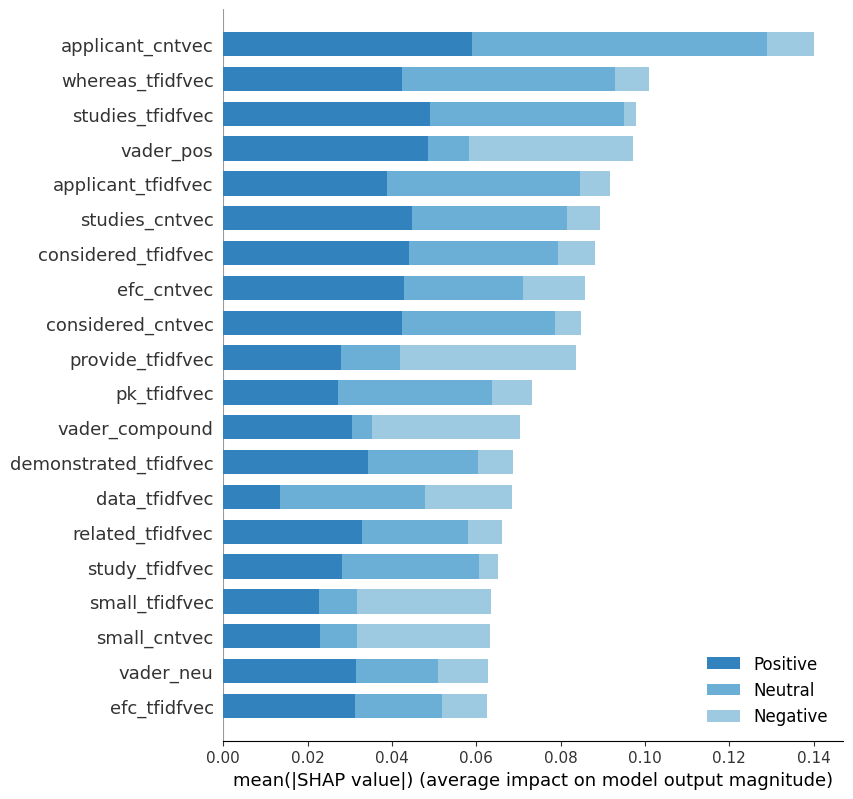

In [28]:
# create SHAP summary plot 
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", class_names= le.classes_, feature_names = X_train.columns, color=plt.get_cmap("tab20c"))

Force plot for test sample with index 1 classified as positive


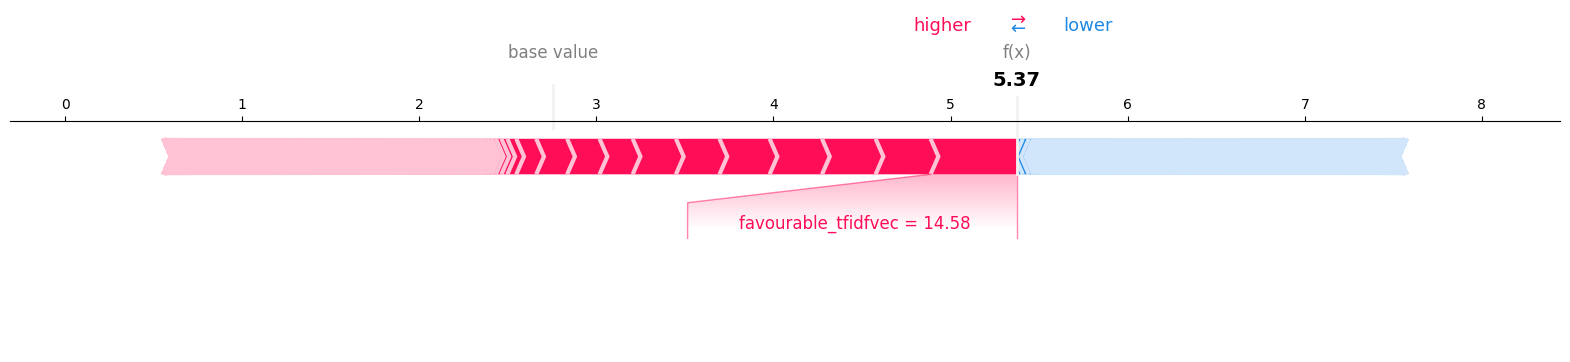

In [29]:
# create SHAP force plot for positive instance

idx = 1
# only explain prediction for top class
c = predictions[idx]

print('Force plot for test sample with index {} classified as {}'.format(idx, le.classes_[c].lower()))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test_scaled[idx].round(2), feature_names = X_train.columns, matplotlib=True)

Force plot for test sample with index 45 classified as neutral


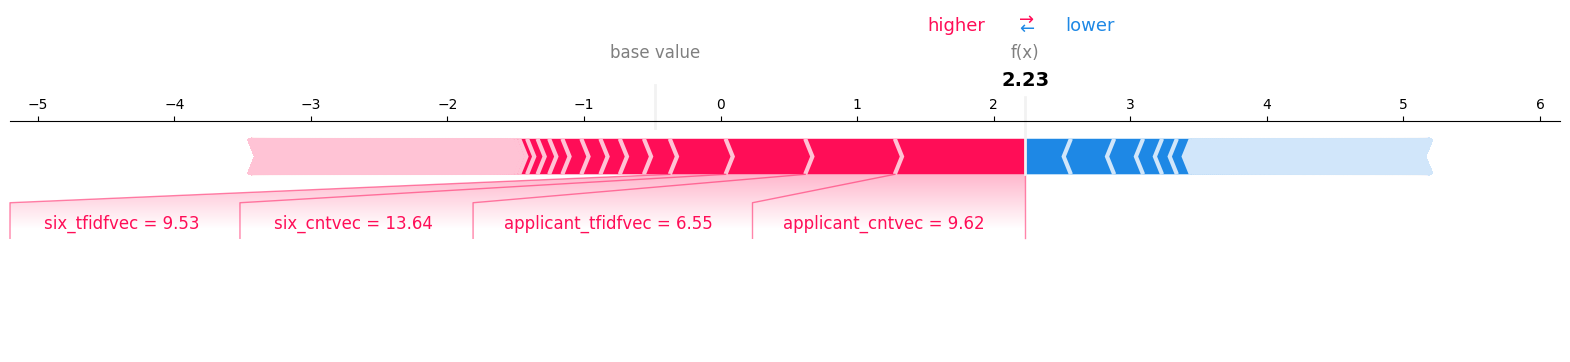

In [30]:
# create SHAP force plot for neutral instance
idx = len(predictions)-2
# only explain prediction for top class
c = predictions[idx]

print('Force plot for test sample with index {} classified as {}'.format(idx, le.classes_[c].lower()))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test_scaled[idx].round(2), feature_names = X_train.columns, matplotlib=True)

Force plot for test sample with index 0 classified as negative


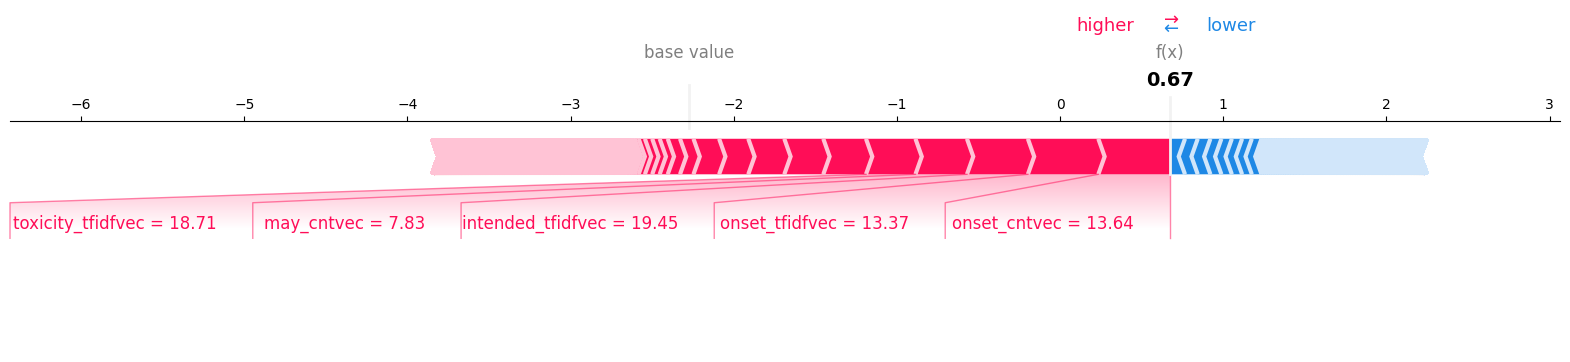

In [31]:
# create SHAP force plot for negative instance
idx = 0
# only explain prediction for top class
c = predictions[idx]

print('Force plot for test sample with index {} classified as {}'.format(idx, le.classes_[c].lower()))

shap.force_plot(explainer.expected_value[c], shap_values[c][idx,:], X_test_scaled[idx].round(2), feature_names = X_train.columns, matplotlib=True)
